# ARIMA theory

ARIMA stands for Autoregressive Integrated Moving Average. It is a class of statistical modelling for analysing and forecasting time series data. The explanations to its components are below:

    - AR: Autogressive: This is a model that uses the dependent relationship between the observations and some number of lagged obserservations.
    - I: Integrated: This is the use of differencing raw observations in order to make the time series stationary.
    - MA: Moving Average: The model uses the dependency betwween the observations and the residual errors from a moving average model that is applied to lagged ovservations.
    
The parameters of an ARIMA are usually expressed as the following:
    - p: the number of lagged observations in the model (lag order).
    - d: the number of times the raw observations are differenced, also called the degree of differencing.
    - q: the size of the moving average window.

We also need to account for stationarity when applying an ARIMA model to a time series. A series or data set is considered stationary when its statistical properties does not depend on the time at which the series is observed. This is important because it helps us to identify factors when there is a change in the time series. This may help us to identify some sort of correlation which is only valid if the time series is stationary.

# Initial Config

In [1]:
#Get relevant libraries
import requests
import pandas as pd
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import urllib.request, json
import warnings
import statsmodels.api as sm

# Initial visualisations

The data for this analysis comes from the European Centre for Disease Prevention and Control. The data is available in a variety of formats and the one we use in JSON.

In [2]:
#GET JSON FILE
#Open the JSON file
with urllib.request.urlopen('https://opendata.ecdc.europa.eu/covid19/casedistribution/json/') as url:
    data = json.loads(url.read().decode('utf-8-sig'))

#Make a list of nested dictionaries
data = data['records']

#Put into dataframe
df = pd.DataFrame(data)

In [3]:
df.head()

,cases,countriesAndTerritories,countryterritoryCode,dateRep,day,deaths,geoId,month,popData2018,year
0,35,Afghanistan,AFG,05/04/2020,5,1,AF,4,37172386,2020
1,0,Afghanistan,AFG,04/04/2020,4,0,AF,4,37172386,2020
2,43,Afghanistan,AFG,03/04/2020,3,0,AF,4,37172386,2020
3,26,Afghanistan,AFG,02/04/2020,2,0,AF,4,37172386,2020
4,25,Afghanistan,AFG,01/04/2020,1,0,AF,4,37172386,2020


In [4]:
#Set the date column to a date that panda likes and will be easy to plot.
df['dateRep'] = pd.to_datetime(df['dateRep'], format='%d/%m/%Y')

In [5]:
#We make a dataframe for the only the worldwide cases in order to complete analysis
df_cases = df[['dateRep', 'cases']]
df_cases = df_cases.astype({'cases': 'float64'})

In [6]:
#We pivot the data to make it easier to plot
df_cases_pivot = pd.DataFrame(df_cases.groupby('dateRep')['cases'].sum())

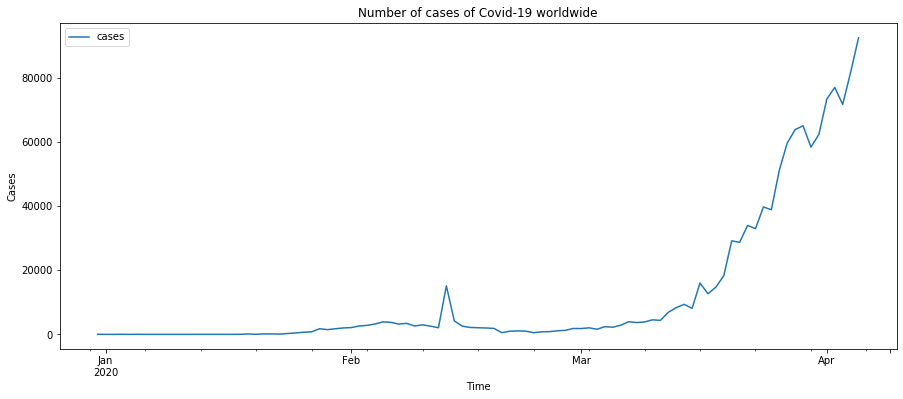

In [7]:
#We plot the pivoted case data to see how the number of cases of Covid-19 has progressed worldwide
df_cases_pivot.plot.line(figsize=(15,6))
plt.ylabel('Cases')
plt.xlabel('Time')
plt.title('Number of cases of Covid-19 worldwide')
plt.show()

# ARIMA analysis - Worldwide

In [8]:
#This is where we import the ARIMA model and start to give it all the relevant parameters.
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [9]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_cases_pivot,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [10]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 888.5324140369513 for model SARIMAX(3, 1, 0)x(3, 1, 0, 12)


In [11]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(df_cases_pivot,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

We will first do a validation of our ARIMA model to see how well our model can predict the number of cases worldwide versus how many actual cases have been reported.

In [12]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()

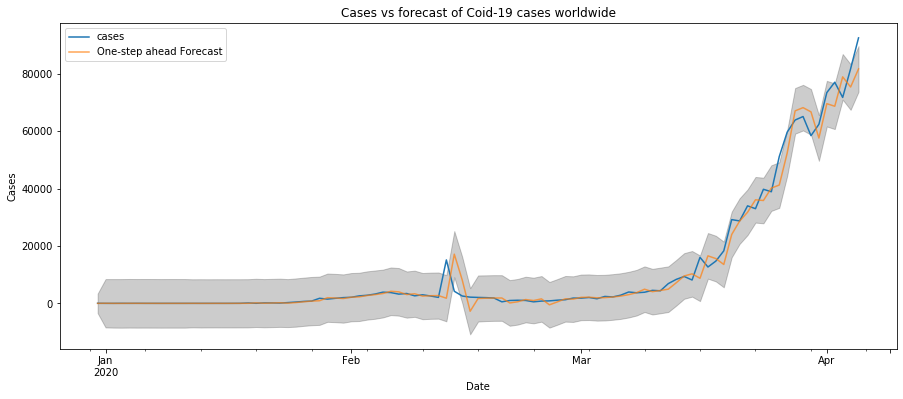

In [13]:
ax = df_cases_pivot.plot(label='observed', figsize=(15,6))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_title('Cases vs forecast of Coid-19 cases worldwide')
ax.set_ylabel('Cases')
plt.legend()

plt.show()

We can see from the above plot that our ARIMA model predicts fairly well, to a certain degree of accuracy, the number of Covid-19 cases worldwide.

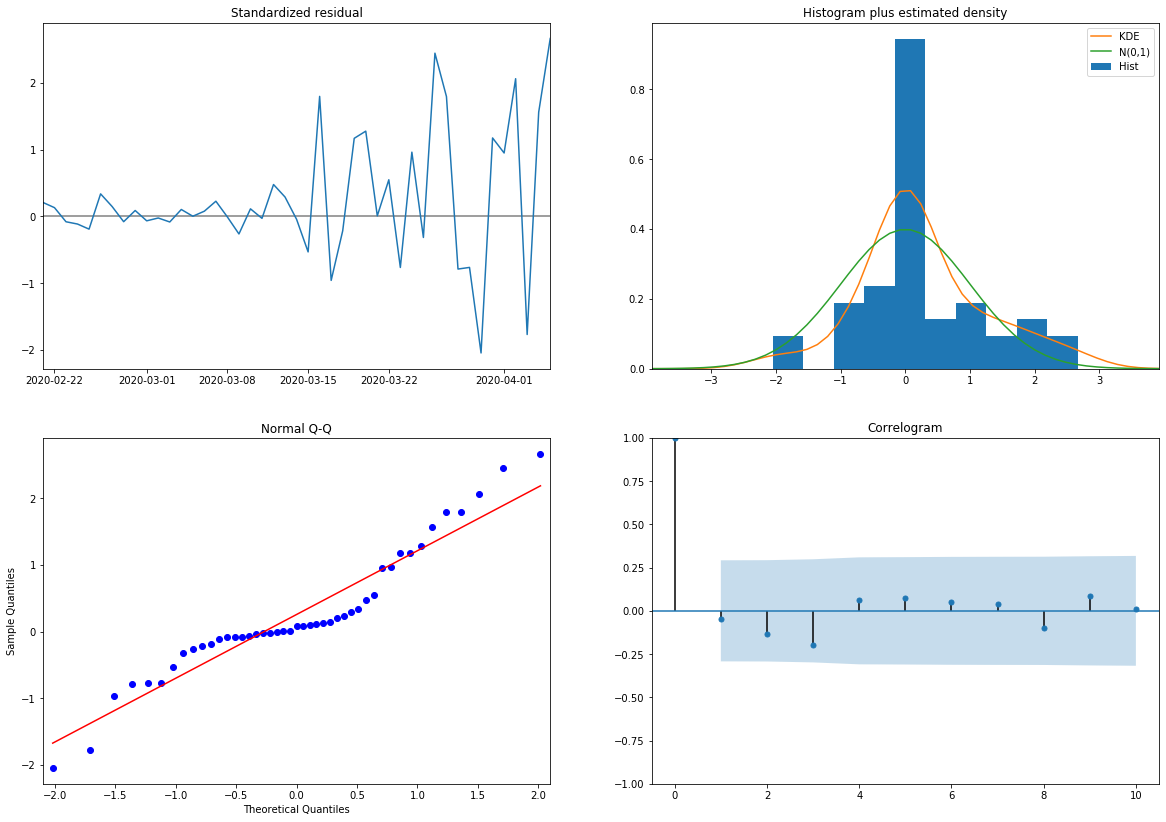

In [14]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In order for our model to be valid and robust, we want to make sure that the residuals of our model are uncorrelated and normally distributed with a zero-mean. In this case, the above plots show that the model residuals are fairly normally distributed.

Using this, we will conclude that our model produces a satisfactory fit that could help understand the trend of Covid-19 cases worldwide and forecast the values.

In [15]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

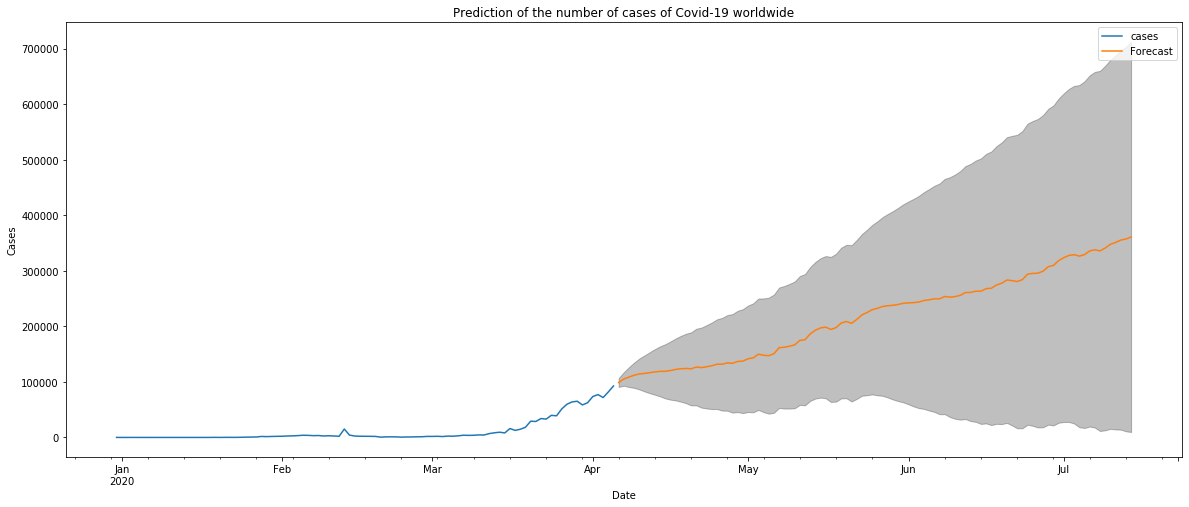

In [16]:
ax = df_cases_pivot.plot(label='observed', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title('Prediction of the number of cases of Covid-19 worldwide')

plt.legend()
plt.show()

The above forecast shows the number of Covid-19 cases worlwide is bound to increase even until July. This makes sense as the global center of the virus has shifted from Wuhan to Italy and now finally the US. This means that although China, in a large part, was able to halt the spread of the virus using tough quarantine measures, it has taken longer for other countries such as the US and Italy to be able to implement these measures.

Sources:https://www.bbc.co.uk

# ARIMA analysis - UK

We will now repeat the same analysis but only looking at the United Kingdom. We want to be able to predict and get an idea on the timeframes it will take for Covid-19 to experience a slowdown as well as predict how long a lockdown should be in effect for.

In [17]:
#We will isolate a dataframe containing data only for the UK
df_uk = df.loc[df['countriesAndTerritories'] == 'United_Kingdom']

In [18]:
#We make a dataframe for the only the UK cases in order to complete analysis
df_cases_uk = df_uk[['dateRep', 'cases']]
df_cases_uk = df_cases_uk.astype({'cases': 'float64'})

In [19]:
#We pivot the data to make it easier to plot
df_cases_pivot_uk = pd.DataFrame(df_cases_uk.groupby('dateRep')['cases'].sum())

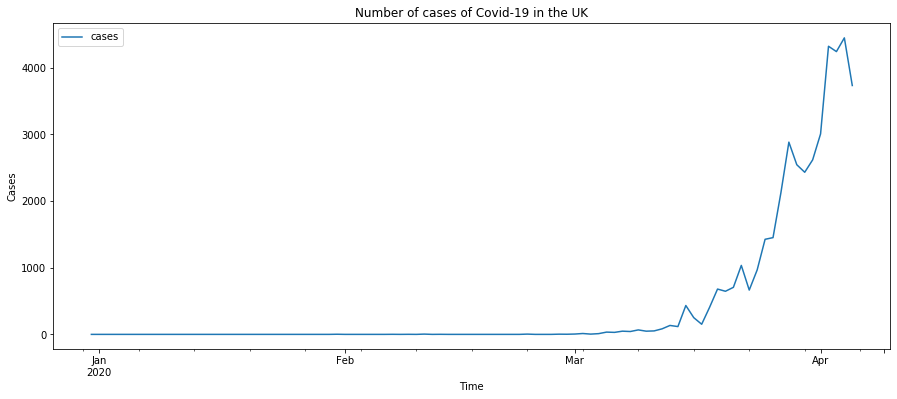

In [20]:
#We plot the pivoted case data to see how the number of cases of Covid-19 has progressed in the UK
df_cases_pivot_uk.plot.line(figsize=(15,6))
plt.ylabel('Cases')
plt.xlabel('Time')
plt.title('Number of cases of Covid-19 in the UK')
plt.show()

From the above plot, we can see that there has been exponential increase in cases since March 2020 with certain dips taking place. This would suggest that the UK is still a long way away from reaching the peak of cases.

In [21]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_cases_pivot_uk,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [22]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 655.2151090645866 for model SARIMAX(3, 1, 1)x(3, 1, 0, 12)


In [23]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(df_cases_pivot_uk,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [24]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()

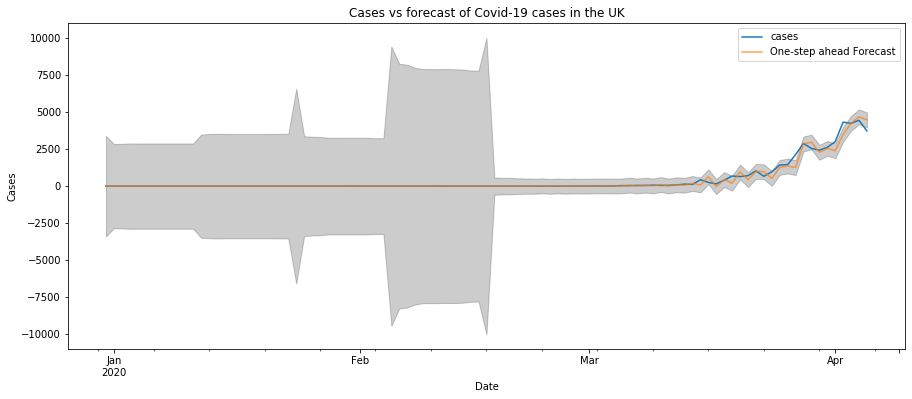

In [25]:
ax = df_cases_pivot_uk.plot(label='observed', figsize=(15,6))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_title('Cases vs forecast of Covid-19 cases in the UK')
ax.set_ylabel('Cases')
plt.legend()

plt.show()

Our above forecast shows that the ARIMA model is able to predict fairly accurately the trend of Covid-19 cases in the UK and being able to capture, to some degree, the dips in cases we have seen.

In [26]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

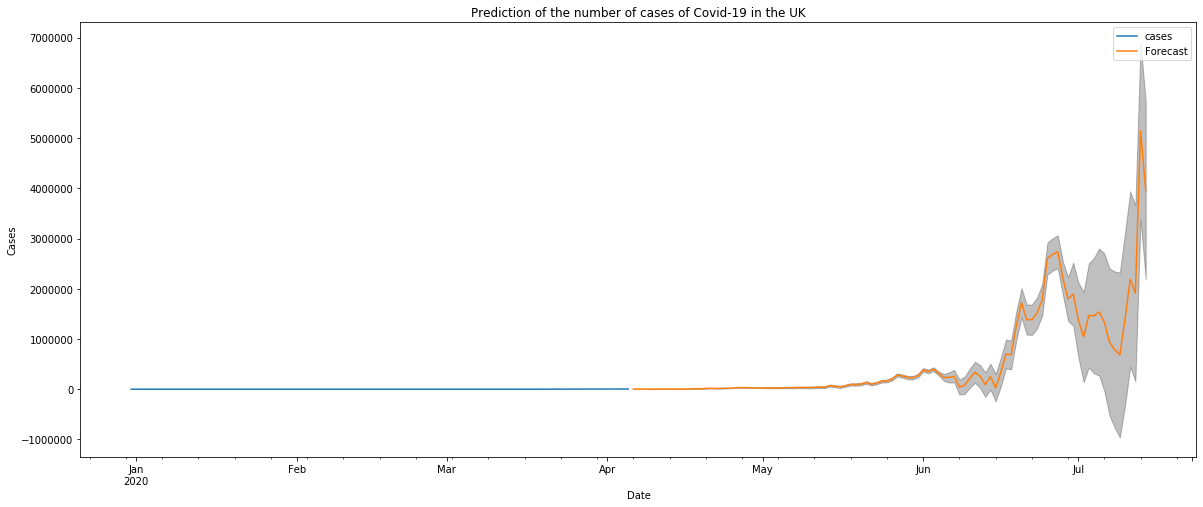

In [27]:
ax = df_cases_pivot_uk.plot(label='observed', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title('Prediction of the number of cases of Covid-19 in the UK')

plt.legend()
plt.show()

Our prediction above shows that even through to July 2020, we do not see the peak of Covid-19 cases being reached. Rather, we see a dip after July and a sharp increase after that as we move into August. Indeed this is to be expected, as cases of virus of this nature happens in waves. This wave-like pattern has been seen before in other pandemics that have plagued the world.

Sources:
- http://www.euro.who.int/en/health-topics/communicable-diseases/influenza/data-and-statistics/pandemic-influenza/about-pandemic-phases
- https://www.nhs.uk/news/heart-and-lungs/pandemic-waves/
- https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0060343&type=printable